In [1]:
import sys
print(sys.executable)

/Users/ibhallaladd/Desktop/venv/bin/python


In [2]:
from __future__ import division # Force python to turn integer division into a float result! Otherwise your fake rates will be all 0...
%load_ext autoreload
%autoreload 2
import os
import sys
import argparse
import glob
import numpy as np
import uproot
import pandas as pd
import pickle
import tables
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy import integrate


plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 14
pd.options.mode.chained_assignment = None  

In [29]:
# Grab a Ztautau sample with neutrino data saved
f = uproot.open("/Users/ibhallaladd/Desktop/hleptons_ztautau_lephad_mmc_test_file.root")
variables = [var.decode() for var in f["NOMINAL"].keys()] 
a = f["NOMINAL"].arrays(variables)

### New in Python3: decode bytestrings into actual strings, otherwise the strings won't be recognized below
def convert(data):
    if isinstance(data, bytes):  return data.decode()
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return tuple(map(convert, data))
    if isinstance(data, list):   return list(map(convert, data))
    return data
a = convert(a)

df = pd.DataFrame.from_dict(a)

In [30]:
vars = df.keys()
[var for var in vars if "pion" in var]

['tau_0_matched_n_charged_pion',
 'tau_0_matched_n_neutral_pion',
 'tau_0_matched_vis_neutral_pions_p4']

In [31]:
def fit_function(x, p0, p1, p2, p3, p4):
    return (p0 * np.exp(-0.5*((x-p1)/p2)**2) + np.exp(p3 + p4*x)) # gaussian + exponential

In [32]:
def fit_nuTau(x, p0, p1, p2):
    return (p0 * np.exp(-0.5*((x-p1)/p2)*((x-p1)/p2)))

In [33]:
def log_normal(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*(np.log((x+p2)/p3))**2)) #lognormal curve - log or log10?

In [34]:
def fit_pT(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*np.sqrt(x)) + p2 + p3*x)

In [35]:
#this is the main method for fitting the histogram, if NOT pT dependent
michael_had_nuTauRatio = 0.2 #this is placeholder
def calculate_hist(pdf, pdf_name, func, m_params, m_integral, bins, integralCheck=michael_had_nuTauRatio):
    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    print("bin width: " + str(np.diff(bin_borders)[0]))
    michael_integral, error = integrate.quad(integralCheck, a=bins[0], b=bins[-1])
    print('michael integral): ' + str(michael_integral))
    
    popt, _ = curve_fit(func, bin_centers, bin_heights, maxfev=1000000, p0=m_params)
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit')
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16)
    
    #uncomment to save fig
    #plt.savefig('/Users/ibhallaladd/Desktop/'+ pdf_name + '_test.root')

    print("Michael's Params | " + str(m_params))
    print("My Params        | " + str(popt))
    #return popt

In [36]:
#this is the main method for fitting the histogram (without michael) and PT dependent 
def calculate_hist_pT(pdf, pdf_name, func, bins):
    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2 
    popt, pcov = curve_fit(func, bin_centers, bin_heights, maxfev=1000000)


    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    #ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit: ' +str(popt))
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    print("My Params        | " + str(popt))
    
    return popt


In [37]:
#THIS CELL IMPORTS AND NAMES EVERYTHING (AND TAKES OUT SOME 0 ENTRIES SO WE CAN MANIP THEM)
for row in tqdm(df.index, total=len(df)):
    
    #NUTAUANGLE3D-HADRONIC
    df.at[row,"tau_0_p_x"] = df.at[row,"tau_0_p4"].x
    df.at[row,"tau_0_matched_decay_neutrino_p_x"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].x
    df.at[row,"tau_0_p_y"] = df.at[row,"tau_0_p4"].y
    df.at[row,"tau_0_matched_decay_neutrino_p_y"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].y
    df.at[row,"tau_0_p_z"] = df.at[row,"tau_0_p4"].z
    df.at[row,"tau_0_matched_decay_neutrino_p_z"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].z
    df.at[row,"tau_0_p_p"] = df.at[row,"tau_0_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_mass"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].mass
    
    #NUTAUANGLE3D-LEPTONIC (note: neutrino info is in MeV, while everything else is in GeV)
    df.at[row,"tau_1_p_x"] = df.at[row,"tau_1_p4"].x
    df.at[row,"tau_1_matched_decay_neutrino_p_x"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].x/(10**3)
    df.at[row,"tau_1_p_y"] = df.at[row,"tau_1_p4"].y
    df.at[row,"tau_1_matched_decay_neutrino_p_y"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].y/(10**3)
    df.at[row,"tau_1_p_z"] = df.at[row,"tau_1_p4"].z
    df.at[row,"tau_1_matched_decay_neutrino_p_z"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].z/(10**3)
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)
    
    #NUTAURATIO-HADRONIC
    df.at[row,"tau_0_p"] = df.at[row,"tau_0_p4"].p #checked
    #trying commented out ones
    #df.at[row,"tau_0_p"] = df.at[row, "tau_0_matched_vis_p4"].p
    df.at[row,"tau_0_matched_decay_neutrino_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p #checked
    
    #NUTAURATIO-LEPTONIC  
    df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
    df.at[row,"tau_1_matched_decay_neutrino_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)


#PRESELECTION
#we want to apply a loose pre-selection, so that we preserve validation and control regions 
    
#TAU-RELATED REQUIREMENTS
# has 1 or 3 prongs - I think that's already encoded somehow 
# has charge of abosolute value 1 - done, didnt change anything 
# has pT>20 GeV - changed A LOT when applied to tau_1 (is that where it is meant to go?)
# not in eta crack region (1.37-1.52)
# jet RNN trans > 0.01
    
df = df[df.tau_0_p_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p_p > 0]


df = df[df.tau_0_p > 0]
df = df[df.tau_0_matched_decay_neutrino_p > 0]

df = df[df.tau_1_p_p > 0]
df = df[df.tau_1_matched_decay_neutrino_p > 0]

df = df[np.abs(df.tau_0_matched_q) ==1.0]

df = df[df.tau_0_allTrk_pt > 20.0] #is this fair?, didnt change anyting 
df = df[(df.tau_1_trk_pt/(10**3)) > 9.0] #changed a lot, does this also apply to subleading?

#df = df[(df.tau_0_allTrk_eta > 1.37) & (df.tau_0_allTrk_eta < 1.52)]
#df = df[(df.tau_1_cluster_eta > 1.37) & (df.tau_1_cluster_eta < 1.52)]

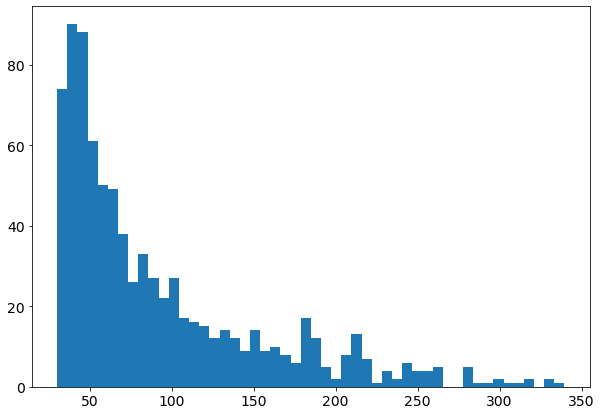

In [18]:
bin_heights, bin_borders, _ = plt.hist(df.tau_0_p, bins=50, density=False, label='histogram')


In [38]:
def find_slices(hist, pT, desired_bins):
    threshold = np.ceil(len(hist)/desired_bins) #how many events in each pT bin
    print(threshold)
    previous = 0
    ranges = [[0,0]]
    
    #step through ordered pT, and add a cut when you reach the threshold, then reset
    for vals in np.sort(pT):
        eggs = len(hist[(pT>previous)&(pT<vals)]) #how many eggs in the basket?
        if (eggs == threshold) or (vals == np.sort(pT)[len(pT)-1]): #control for last bin
            ranges.append([previous, vals])#this is your pT cut 
            previous = vals
    ranges.pop(0)
    return ranges  

nuTauAngle_had = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))
print(len(nuTauAngle_had[(df.tau_0_n_charged_tracks==1)&(df.tau_0_matched_n_neutral_pion==0)]))
test_ranges = find_slices(nuTauAngle_had[(df.tau_0_n_charged_tracks==1)&(df.tau_0_matched_n_neutral==0)], df.tau_0_allTrk_pt, 4)


380
81.0


weighted_pT_cuts[13.63044071 26.70501137 31.56890488 51.72438431]
My Params        | [2.62832783e+01 7.72092002e-01 7.75446350e-04 1.36636281e-02]
My Params        | [ 3.06031007e+01  3.63466858e-01 -3.44493450e-03  6.12610754e-03]
My Params        | [19.36768056  3.34689965  0.02392955  0.04838496]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


My Params        | [18.76320738  4.57719354  0.038646    0.063192  ]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(-100.0, 120.0)

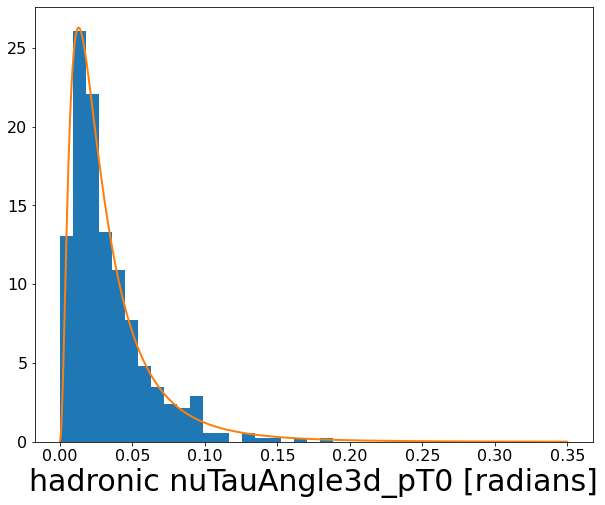

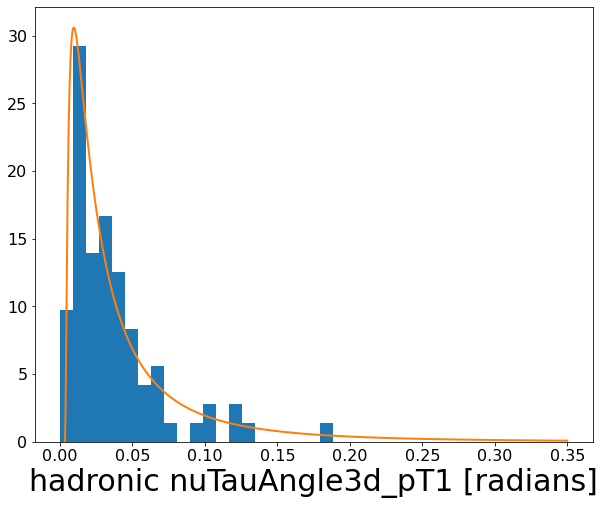

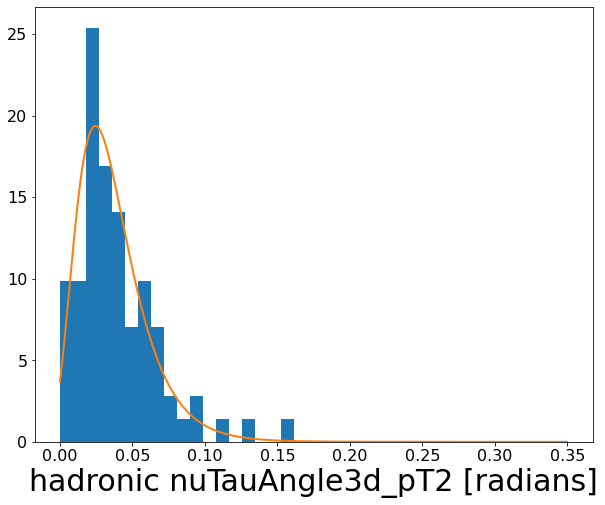

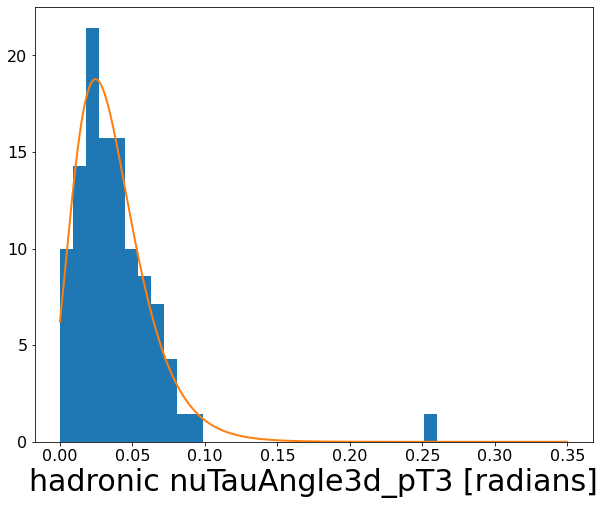

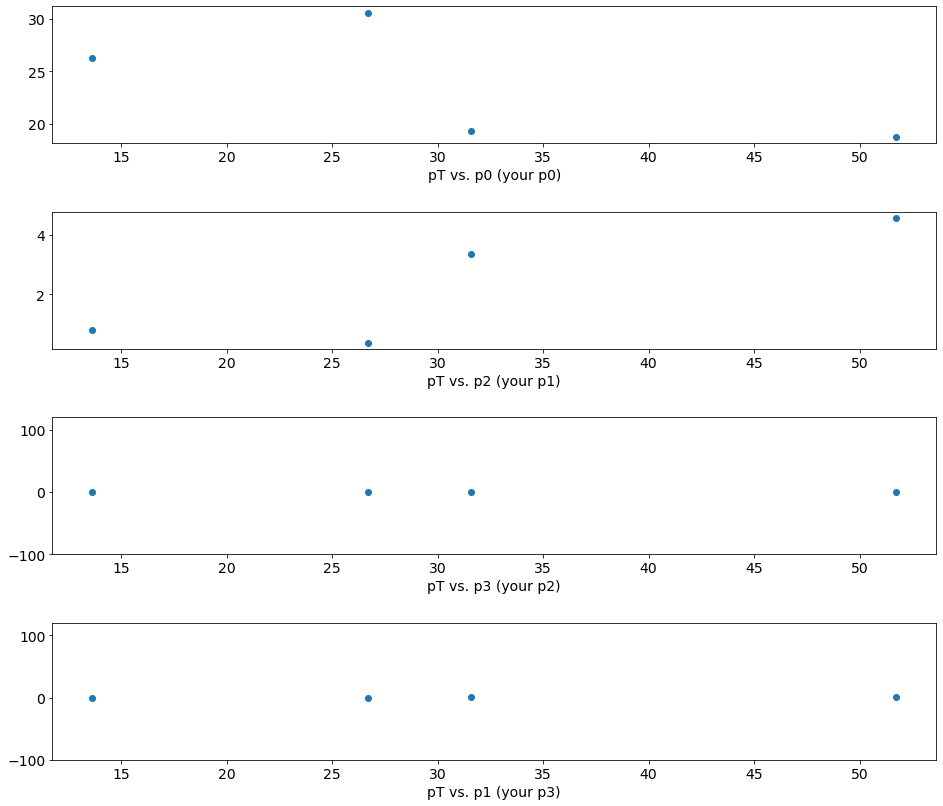

In [20]:
#working on new PDFs

#cuts = [[0, 22.336124], [22.336124, 24.417652], [24.417652, 26.869095], [26.869095, 28.963282], [28.963282, 31.862545], [31.862545,35.37512], [35.37512, 43.03933], [43.03933, 400]]
cuts = [[0, 24.32966], [24.32966, 28.858505], [28.858505, 35.070118], [35.070118, 400.0]]
#cuts = [[0, 21.909164], [21.909164, 24.197727], [24.197727, 26.539545], [26.539545, 28.858505], 
       # [28.858505, 31.764616], [31.764616, 35.37512], [35.37512, 43.03933], [43.03933, 400.0]]

#changing them to look like Michael's
#cuts = [[0, 40.0], [40.0,45.0], [45.0, 47.0], [47.0, 50.0], [50.0, 57.0], [57.0, 67.0], [67.0,99.0]]

#making weighted pT cuts
weighted_pT_cuts = np.zeros(len(cuts))
i = 0
for elem in cuts: 
    weighted_pT_cuts[i] = np.mean(df.tau_0_allTrk_pt[(df.tau_0_allTrk_pt>(elem[0]))&(df.tau_0_allTrk_pt<(elem[1]))]) 
    i = i + 1
    
print('weighted_pT_cuts' + str(weighted_pT_cuts))

par0 = np.zeros(len(cuts))
par1 = np.zeros(len(cuts))
par2 = np.zeros(len(cuts))
par3 = np.zeros(len(cuts))

count = 0
for slice in cuts:
    nuTauAngle_had_pT = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                            (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                               (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_allTrk_pt>(cuts[count][0]))&(df.tau_0_allTrk_pt<(cuts[count][1]))&(df.tau_0_n_charged_tracks==1)&(df.tau_0_matched_n_neutral==0)]

    params = calculate_hist_pT(nuTauAngle_had_pT,"hadronic nuTauAngle3d_pT" + str(count)+" [radians]", log_normal, bins=np.linspace(0,0.35,40))
 
    par0[count] = params[0]
    par1[count] = params[1]
    par2[count] = params[2]
    par3[count] = params[3]
    count = count + 1

    #labels are Michael's key

x_interval = np.linspace(0, 200, 1000)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(14,12))
fig.tight_layout(pad=3.0)

#ax0.errorbar(interpolated_cuts, par0, xerr=interpolated_cuts_err)
ax0.scatter(weighted_pT_cuts, par0)
popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=10000000)
#ax0.plot(x_interval, fit_pT(x_interval, *popt0))
ax0.set_xlabel('pT vs. p0 (your p0)')


ax3.scatter(weighted_pT_cuts, par3)
popt3, _ = curve_fit(fit_pT, weighted_pT_cuts, par3, maxfev=1000000)
#ax3.plot(x_interval, fit_pT(x_interval, *popt3))
ax3.set_xlabel('pT vs. p1 (your p3)')
ax3.set_ylim(-100,120)

ax1.scatter(weighted_pT_cuts, par1)
popt1, _ = curve_fit(fit_pT, weighted_pT_cuts, par1, maxfev=1000000)
#ax1.plot(x_interval, fit_pT(x_interval, *popt1))
ax1.set_xlabel('pT vs. p2 (your p1)')

ax2.scatter(weighted_pT_cuts, par2)
popt2, _ = curve_fit(fit_pT, weighted_pT_cuts, par2, maxfev=1000000)
#ax2.plot(x_interval, fit_pT(x_interval, *popt2))
ax2.set_xlabel('pT vs. p3 (your p2)')
ax2.set_ylim(-100,120)
#ax2.set_ylim(-10,100)


#conversion key between your parameters and michael's
#you | Michael
#p0 = p0
#p1 = p2
#p2 = p3
#p3 = p1


In [21]:
#working on new PDF function

def dmode_pdfs(numSlices, dmode):
    
    prongN = 0
    nupionN = 0
    
    if   dmode=='1p0n':
        prongN = 1
        nupionN = 0
    elif dmode=='1p1n':
        prongN = 1
        nupionN = 1
    elif dmode=='1pXn':
        prongN = 1
        nupionN = 2
    elif dmode=='3p0n':
        prongN = 3 
        nupionN = 0
    elif dmode=='3pXn':
        prongN = 3
        nupionN = 1
        
    nuTauAngle_dmode = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                                (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                                   (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_n_charged_tracks==prongN)&(df.tau_0_matched_n_neutral==nupionN)]

    cuts = find_slices(nuTauAngle_dmode, df.tau_0_allTrk_pt, numSlices)

    weighted_pT_cuts = np.zeros(len(cuts))
    i = 0

    for elem in cuts: 
        weighted_pT_cuts[i] = np.mean(df.tau_0_allTrk_pt[(df.tau_0_allTrk_pt>(elem[0]))&(df.tau_0_allTrk_pt<(elem[1]))])
        i = i + 1
    
    print('weighted_pT_cuts' + str(weighted_pT_cuts))

    par0 = np.zeros(len(cuts))
    par1 = np.zeros(len(cuts))
    par2 = np.zeros(len(cuts))
    par3 = np.zeros(len(cuts))

    count = 0
    for slice in cuts:
        nuTauAngle_had_pT = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                                (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                                   (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_allTrk_pt>(cuts[count][0]))&(df.tau_0_allTrk_pt<(cuts[count][1]))&(df.tau_0_n_charged_tracks==prongN)&(df.tau_0_matched_n_neutral_pion==nupionN)]
        
        params = calculate_hist_pT(nuTauAngle_had_pT,"hadronic nuTauAngle3d_pT" + str(count)+" [radians]", log_normal, bins=np.linspace(0,0.35,40))

        par0[count] = params[0]
        par1[count] = params[1]
        par2[count] = params[2]
        par3[count] = params[3]
        count = count + 1

        #labels are Michael's key

    x_interval = np.linspace(0, 200, 1000)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(14,12))
    fig.tight_layout(pad=3.0)

    #ax0.errorbar(interpolated_cuts, par0, xerr=interpolated_cuts_err)
    ax0.scatter(weighted_pT_cuts, par0)
    popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=10000000)
    #ax0.plot(x_interval, fit_pT(x_interval, *popt0))
    ax0.set_xlabel('pT vs. p0 (your p0)')


    ax3.scatter(weighted_pT_cuts, par3)
    popt3, _ = curve_fit(fit_pT, weighted_pT_cuts, par3, maxfev=1000000)
    #ax3.plot(x_interval, fit_pT(x_interval, *popt3))
    ax3.set_xlabel('pT vs. p1 (your p3)')
    ax3.set_ylim(-100,120)

    ax1.scatter(weighted_pT_cuts, par1)
    popt1, _ = curve_fit(fit_pT, weighted_pT_cuts, par1, maxfev=1000000)
    #ax1.plot(x_interval, fit_pT(x_interval, *popt1))
    ax1.set_xlabel('pT vs. p2 (your p1)')

    ax2.scatter(weighted_pT_cuts, par2)
    popt2, _ = curve_fit(fit_pT, weighted_pT_cuts, par2, maxfev=1000000)
    #ax2.plot(x_interval, fit_pT(x_interval, *popt2))
    ax2.set_xlabel('pT vs. p3 (your p2)')
    ax2.set_ylim(-100,120)
    #ax2.set_ylim(-10,100)

    return weighted_pT_cuts, par0, par1, par2, par3

#conversion key between your parameters and michael's
#you | Michael
#p0 = p0
#p1 = p2
#p2 = p3
#p3 = p1


In [22]:
def dmode_pdfs_noSlice(dmode):
        
    prongN = 0
    nupionN = 0
    
    if   dmode=='1p0n':
        prongN = 1
        nupionN = 0
    elif dmode=='1p1n':
        prongN = 1
        nupionN = 1
    elif dmode=='1pXn':
        prongN = 1
        nupionN = 2
    elif dmode=='3p0n':
        prongN = 3 
        nupionN = 0
    elif dmode=='3pXn':
        prongN = 3
        nupionN = 1
        
    nuTauAngle_dmode = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                                (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                                   (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[(df.tau_0_n_charged_tracks==prongN)&(df.tau_0_matched_n_neutral==nupionN)]
    print('fraction of elements: '+ str(100*(len(nuTauAngle_dmode)/len(df.tau_0_p_x))))

    x_interval = np.linspace(0, 200, 1000)
    fig, ax0 = plt.subplots(figsize=(10,8))
    fig.tight_layout(pad=3.0)

    bin_heights, bin_borders, _ = plt.hist(nuTauAngle_dmode, bins=40, density=False, label='histogram')
    ax0.set_xlabel(str(dmode)+ ' hadronic nuTauAngle3d')
    

fraction of elements: 79.35174069627851


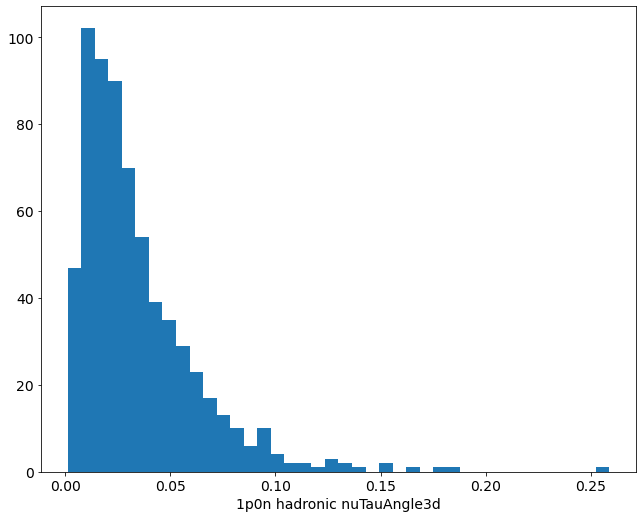

In [26]:
dmode_pdfs_noSlice('1p0n')

83.0
weighted_pT_cuts[ 4.17651176  9.87008381 14.21323872 18.33333397 22.05574799 26.63311768
 31.80245781 62.3896637 ]
My Params        | [ 3.96941118e+01  4.15654055e-01 -3.52529978e-03  5.45640999e-03]
My Params        | [2.19860342e+01 7.76632157e+05 3.45555475e+01 3.45633894e+01]
My Params        | [2.70155438e+01 1.21304834e+00 1.90060466e-03 1.81263317e-02]
My Params        | [2.10458614e+01 5.81531581e-01 1.74275896e-03 1.39994851e-02]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


My Params        | [ 2.76487050e+01  7.36652391e-01 -7.59190673e-04  1.25776919e-02]
My Params        | [ 2.75917501e+01  4.37616301e-01 -2.69766701e-03  8.14758951e-03]
My Params        | [17.51166968  3.37759635  0.0311185   0.05548606]
My Params        | [18.20864135  7.15781907  0.05617071  0.08360989]


/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/ibhallaladd/Desktop/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


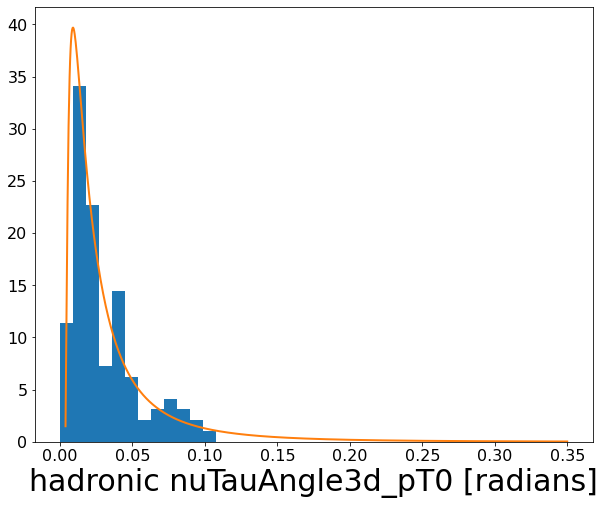

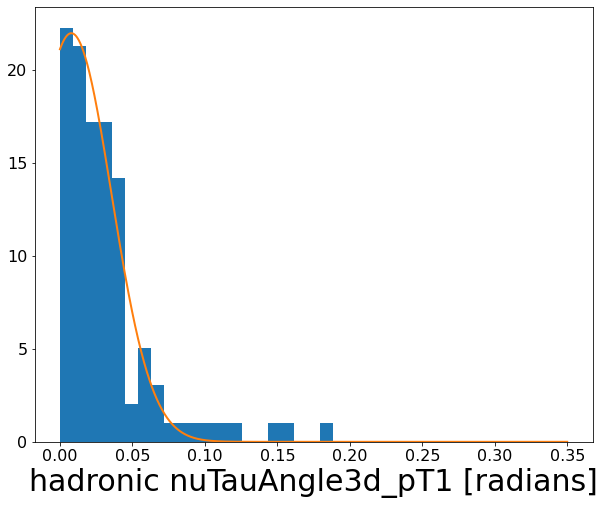

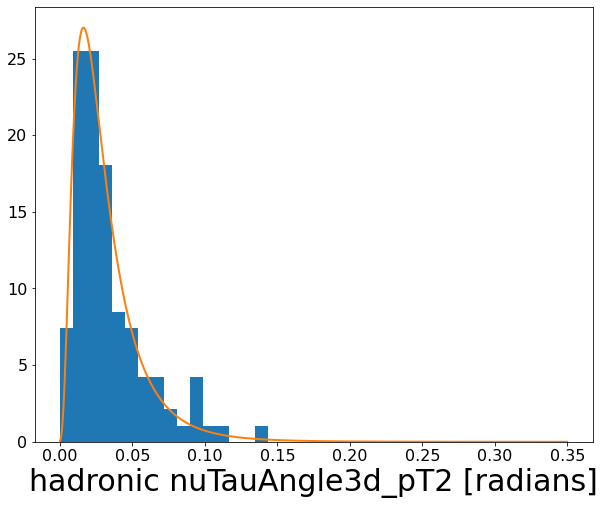

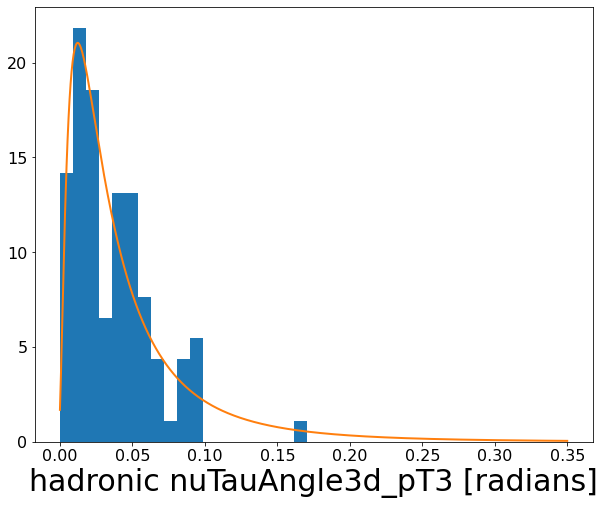

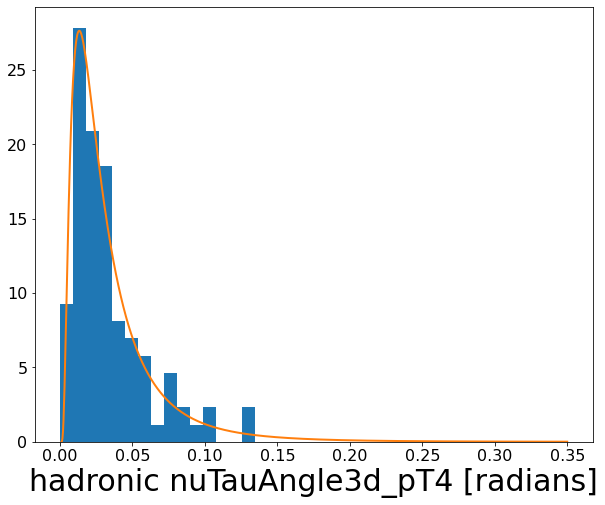

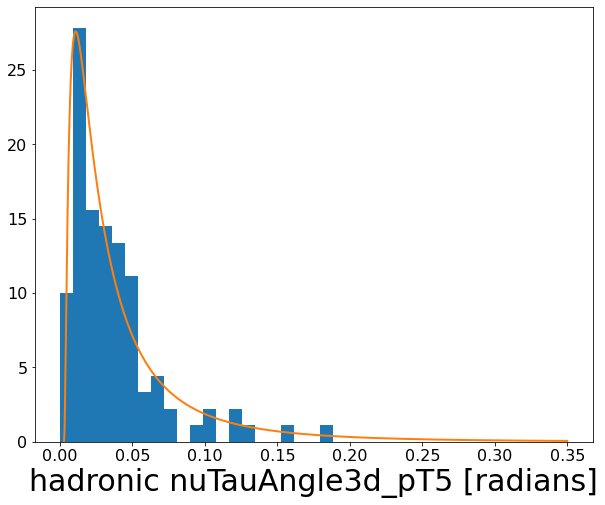

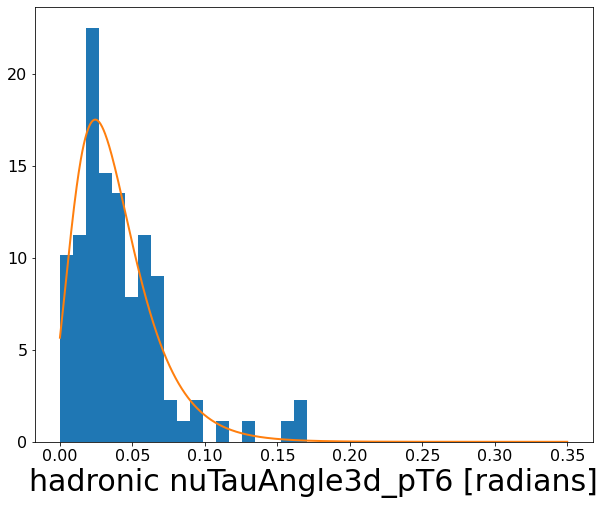

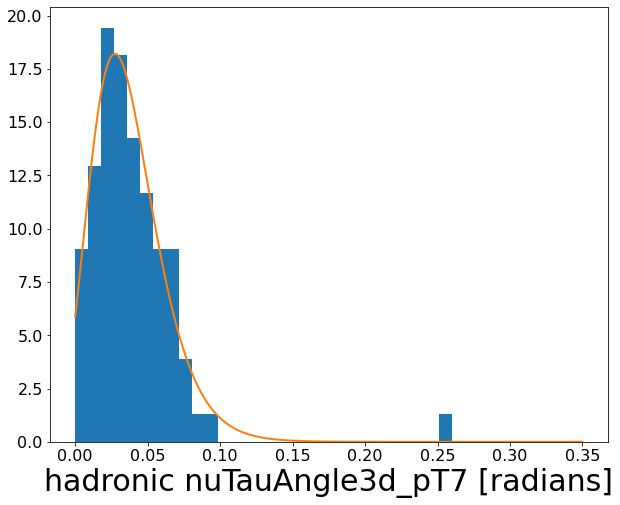

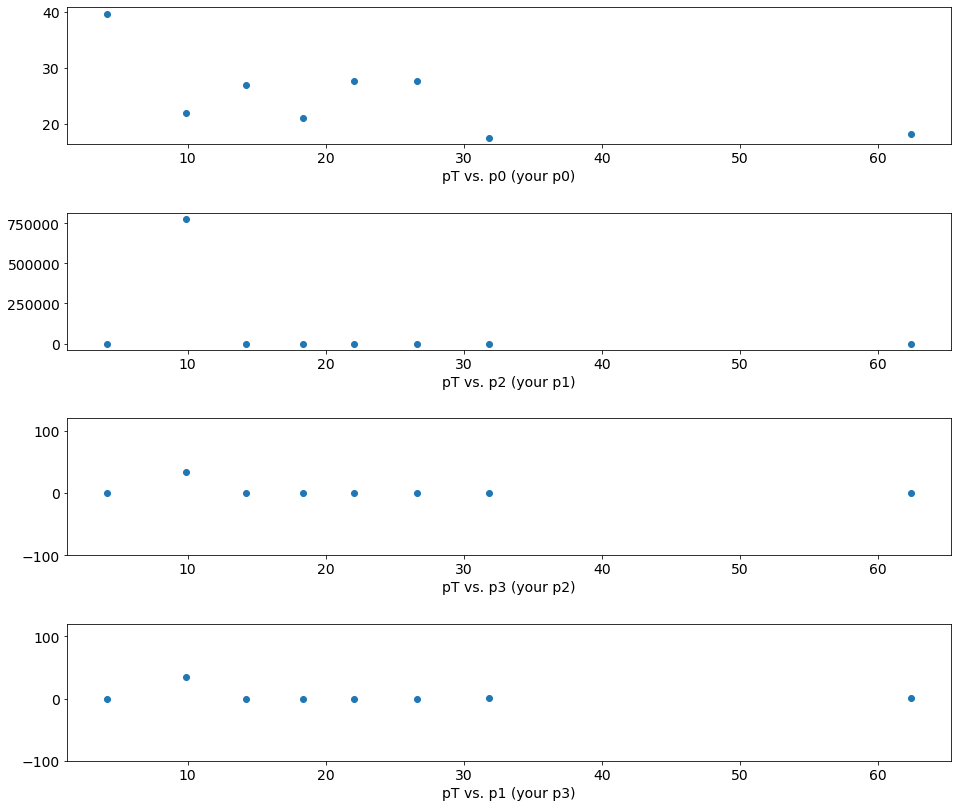

In [24]:
weighted_pT_cuts, par0, par1, par2, par3 = dmode_pdfs(8, '1p0n')

Text(0.5, 0, 'pT vs. params p1')

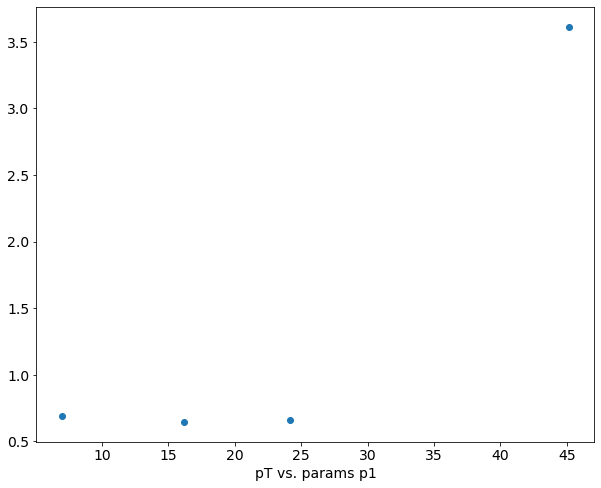

In [65]:
x_interval = np.linspace(0, 100, 1000)
fig, ax3 = plt.subplots(figsize=(10,8))
ax3.scatter(weighted_pT_cuts, par1)
#popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=1000000)
#ax3.plot(x_interval, fit_pT(x_interval, *popt0))
ax3.set_xlabel('pT vs. params p1')
#ax3.set_ylim(0,50)
